# 📘 MobileNetV3 - FER2013 - Train and Evaluation

Ngày thực hiện: 02/05/2025

Notebook này trình bày cách huấn luyện và đánh giá mô hình **MobileNetV3** trên tập dữ liệu cảm xúc khuôn mặt **FER2013**.

Nội dung gồm:
1.	Tải và tiền xử lý dữ liệu
2.	Định nghĩa mô hình (MobileNetV3)
3.	Huấn luyện mô hình
4.	Đánh giá: Độ chính xác (Accuracy), Ma trận nhầm lẫn (Confusion Matrix), Thời gian suy luận (Inference Time), Kích thước mô hình (Model Size)

Cấu trúc thư mục dữ liệu phải được tổ chức thành hai thư mục train/ và test/, mỗi thư mục chứa các thư mục con tương ứng với từng nhãn cảm xúc.


**Note** 
 - Mô hình đã hoạt động tốt hơn, từ 2x ở V1, V2 lên tới gần 60 ở V3. nhưng vẫn chưa đủ


In [4]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input

In [10]:
IMG_SIZE = 224
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '../../Bai_4/data/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../../Bai_4/data/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '../../Bai_4/data/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
base_model = MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,687 (3.90 MB)

 Trainable params: 670,759 (2.56 MB)

 Non-trainable params: 350,928 (1.34 MB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 175s 237ms/step - accuracy: 0.4012 - loss: 1.5448 - val_accuracy: 0.4933 - val_loss: 1.3308
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 182s 253ms/step - accuracy: 0.5521 - loss: 1.2006 - val_accuracy: 0.5138 - val_loss: 1.3623
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 179s 250ms/step - accuracy: 0.6097 - loss: 1.0741 - val_accuracy: 0.5644 - val_loss: 1.2073
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 183s 255ms/step - accuracy: 0.6479 - loss: 0.9735 - val_accuracy: 0.5090 - val_loss: 1.3728
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 184s 256ms/step - accuracy: 0.6743 - loss: 0.8955 - val_accuracy: 0.6036 - val_loss: 1.1292
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 178s 248ms/step - accuracy: 0.7158 - loss: 0.7946 - val_accuracy: 0.5694 - val_loss: 1.2223
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 164s 229ms/step - accuracy: 0.7591 - loss: 0.6897 - val_accuracy: 0.5877 - val_loss: 1.3379
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 166s 232ms/step - accuracy: 0.7872 - loss: 0.58

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - accuracy: 0.5750 - loss: 1.1631
Test Accuracy: 61.37%
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step


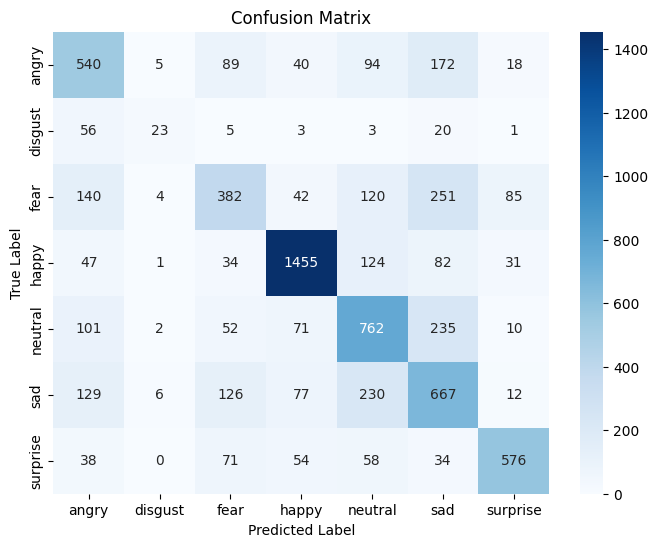

In [11]:
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
# Inference Time
import time
start = time.time()
_ = model.predict(test_generator)
end = time.time()

inference_time = (end - start) / len(test_generator.filenames) * 1000  # ms per image
print(f"Average Inference Time: {inference_time:.2f} ms/image")

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step
Average Inference Time: 11.46 ms/image


In [14]:
model.save("mobilenetv3_fer2013_V3.keras")  # lưu đúng định dạng mới
size_mb = os.path.getsize("mobilenetv3_fer2013_V3.keras") / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

Model Size: 9.59 MB


In [15]:
from sklearn.metrics import f1_score

# F1-Score macro (trung bình đều các lớp)
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# F1-Score micro (toàn bộ TP, FP, FN gộp lại)
f1_micro = f1_score(y_true, y_pred_classes, average='micro')

# F1-Score weighted (có tính đến số lượng mẫu từng lớp)
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1-Score (Macro): {f1_macro * 100:.2f}%")
print(f"F1-Score (Micro): {f1_micro * 100:.2f}%")
print(f"F1-Score (Weighted): {f1_weighted * 100:.2f}%")

F1-Score (Macro): 55.80%
F1-Score (Micro): 61.37%
F1-Score (Weighted): 61.27%
